#Predicting Hydration Free Energy Using the FreeSolv Database#
###University of Copenhagen | Machine Learning and Molecules | Aidan Holland jvg478###

##Theory##
Hydration Free Energy is defined as the amount of energy released when one mole of ions undergoes hydration. It's an important component to consider when quantitatively analyzing the process of solvation, where complexes are formed between the ions of water and whatever solute (and its ions) is in the water.

The Free Solvation Database (FreeSolv) is a dataset of 642 molecules accompanied by their hydration free energy. The most sensible way to engage with the data is to use the molecules and their simplified molecular-input line-entry system (SMILES) to predict the hydration free energy. SMILES is a way to express a molecule, in all of its complexities with atoms and bonds, in a string form that can be processed in other ways. To predict the molecule using the free energy would not be feasible. Given that these are the only two columns, the molecules are the one input and the free energy is the one output.

Throughout Molecules and Machine Learning, we have engaged with new methods of creating predictive models for classification and regression. Classification predicts a qualitative, while regression predicts a quantitative. In Assignment 1, we created two classification models with a variety of inputs that output whether or not a molecule has high solubility. The classification used logistic regression and neural networks to predict. Logistic regression already predicts to a value close to 0 or close to 1, but the activation functions of neural networks have to be outputting a sigmoid to produce similar classifying results.

It would be possible for me to make a class for the FreeSolv data and make a classifying model, but it makes more sense to align the work with Assignment 2 and 3 using neural networks, both a standard linear-predicting one and a graph convolutional one. By using both and analyzing the strength of the models, we can decide which one is best for predicting.

Interestingly, the <a href="https://en.wikipedia.org/wiki/Hydration_energy">hydration energy wikipedia page</a>, citing an article I can't access, states "The value of hydration energies is one of the most challenging aspects of structural prediction." The below image features a value titled delta Fsol. This can be interpreted as the hydration free energy gained or lost when a molecule is ionized and hydrated.

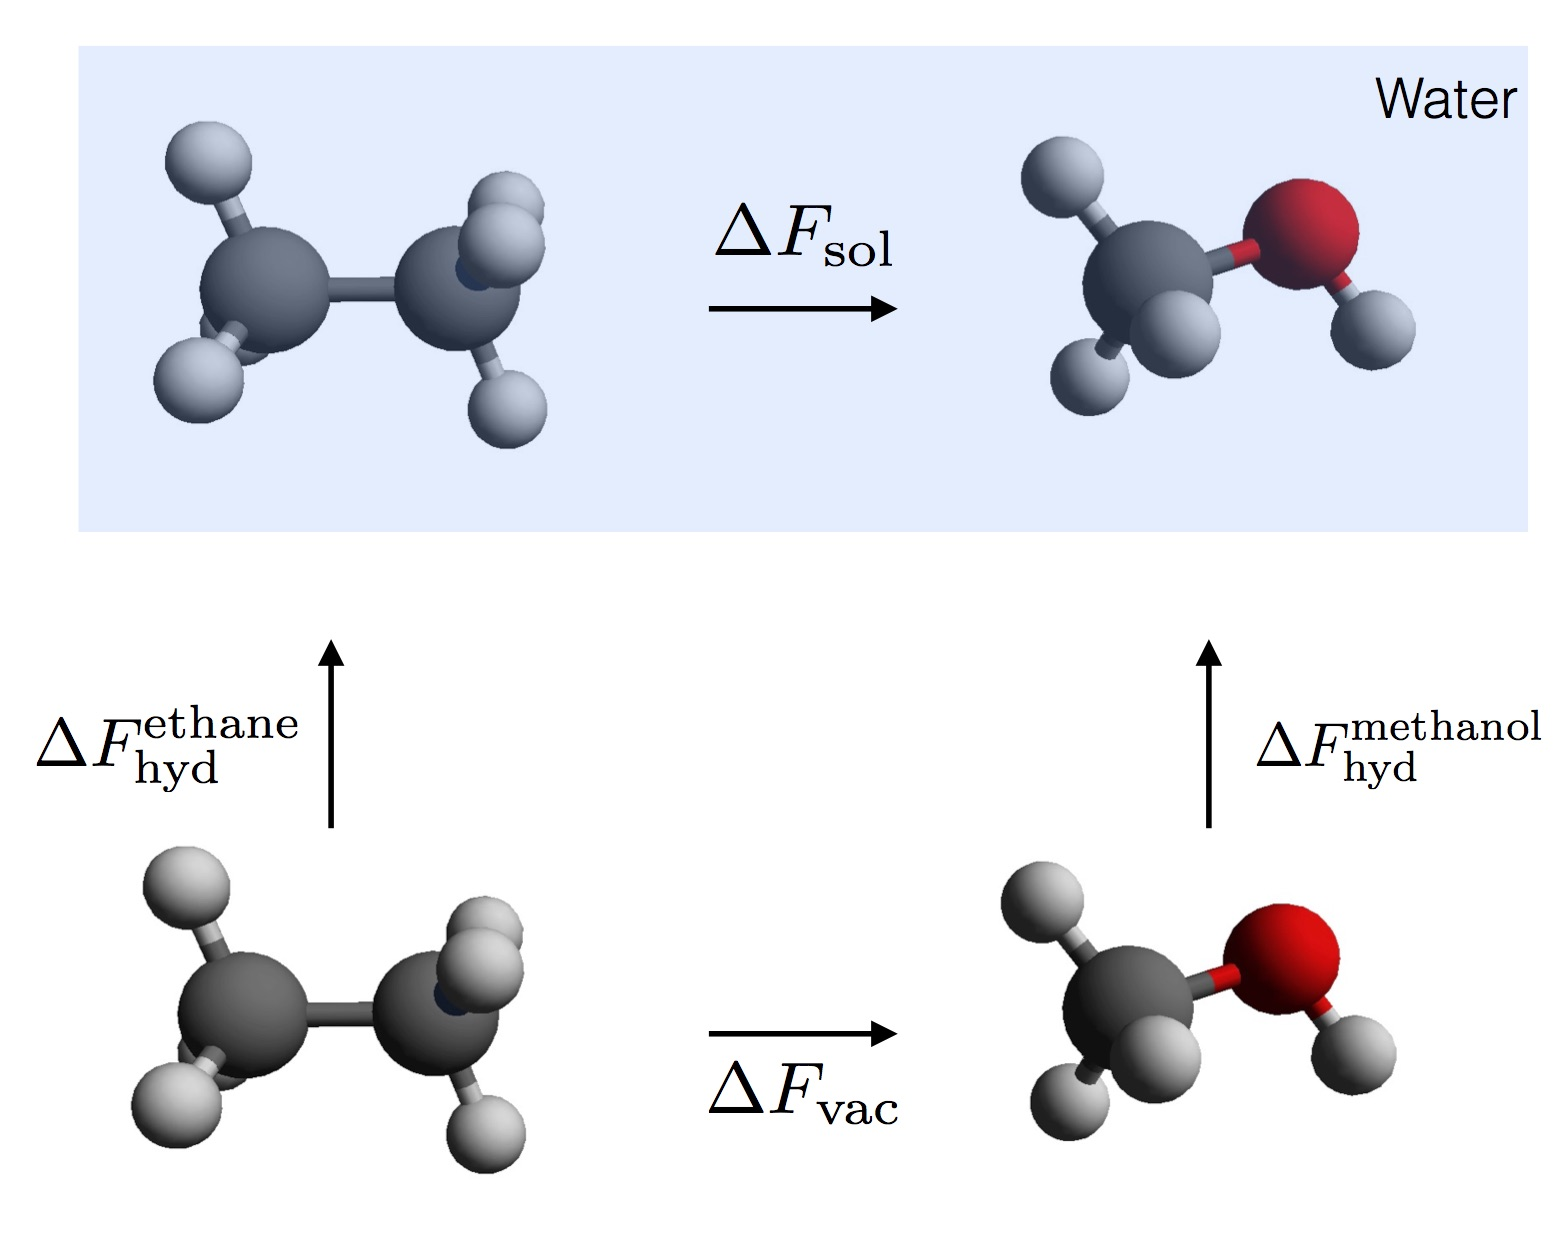

##Data Source and Imported Functions##

In [ ]:
%%capture
!pip install rdkit
!pip install mols2grid
!pip install --pre deepchem

In [ ]:
import pandas as pd
import numpy as np
import deepchem as dc
dc.__version__
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole

from deepchem.molnet import load_freesolv
from deepchem.splits import RandomSplitter
from deepchem.models.layers import GraphConv, BatchNormalization
from deepchem.models import GraphConvModel

In [ ]:
# Raw data
url = 'https://deepchemdata.s3.us-west-1.amazonaws.com/datasets/freesolv.csv.gz'
data = pd.read_csv(url, compression='gzip')
print(data.shape)
data

(642, 2)


,smiles,y
0,CN(C)C(=O)c1ccc(cc1)OC,-1.874467
1,CS(=O)(=O)Cl,-0.277514
2,CC(C)C=C,1.465089
3,CCc1cnccn1,-0.428367
4,CCCCCCCO,-0.105855
...,...,...
637,CCCCCCCC(=O)OC,0.458540
638,C1CCNC1,-0.436169
639,c1cc(ccc1C=O)O,-1.307471
640,CCCCCCCCl,1.064550


##Neural Network Model Using Fingerprint Bit Vector (RMSE ~0.4)##

As a string, the SMILES data could not be simply input to a neural network because its form does not effectively enough convey the structure of the molecule, e.g. where double bonds are versus single. Therefore, we use a SmilesToFPS function to convert all of that SMILES data to something that does convey the structure better. This is the service of the Fingerprint Bit Vector. It is a length of bits, each of which convey a specific feature about the molecule. Graph convolutional neural networks function very similarly but create their own vector to convey different details based on the image of the molecule itself. Below is a sample vector that is very, very simple but shows the idea that a certain value in a certain position in the vector means a certain feature of the molecule.

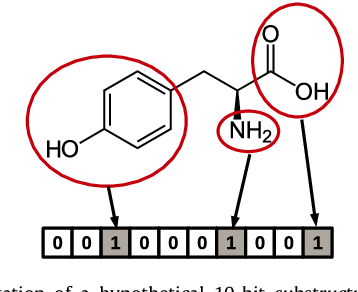

In [ ]:
# Converts SMILES into Fingerprints
def SmilesToFPS(smiles):
  mol = Chem.MolFromSmiles(smiles)
  fps = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
  fps = np.array(fps)
  return fps

# Splitting into train and test data
train, test = train_test_split(data, test_size = 0.05, random_state = 50)
y_train = train['y']
y_test = test['y']
X_train = np.array([SmilesToFPS(smiles) for smiles in train.smiles])
X_test = np.array([SmilesToFPS(smiles) for smiles in test.smiles])

# Model Creation
model = Sequential([
    Dense(1024, activation='relu', input_dim=X_train.shape[1]),
    Dense(256, activation='relu'),
    Dense(1, activation = 'linear'),
])

# Clarifying gradient descent methodology
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer ='adam',
    loss = 'mean_squared_error',
)

# Creating early stop to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
)

# Producing an early error value using the trained model
# Hyperparameters have been selected roughly upon minimizing this value
y_test_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE =",rmse_test)

Epoch 1/1000
18/18 [==============================] - 2s 36ms/step - loss: 0.6359 - val_loss: 0.2341
Epoch 2/1000
18/18 [==============================] - 0s 22ms/step - loss: 0.2349 - val_loss: 0.2064
Epoch 3/1000
18/18 [==============================] - 0s 22ms/step - loss: 0.1118 - val_loss: 0.1508
Epoch 4/1000
18/18 [==============================] - 0s 21ms/step - loss: 0.0525 - val_loss: 0.1408
Epoch 5/1000
18/18 [==============================] - 0s 20ms/step - loss: 0.0268 - val_loss: 0.1281
Epoch 6/1000
18/18 [==============================] - 1s 34ms/step - loss: 0.0162 - val_loss: 0.1363
Epoch 7/1000
18/18 [==============================] - 1s 29ms/step - loss: 0.0132 - val_loss: 0.1183
Epoch 8/1000
18/18 [==============================] - 1s 35ms/step - loss: 0.0102 - val_loss: 0.1318
Epoch 9/1000
18/18 [==============================] - 1s 28ms/step - loss: 0.0105 - val_loss: 0.1190
Epoch 10/1000
18/18 [==============================] - 1s 29ms/step - loss: 0.0118 - val_lo

20/20 [==============================] - 0s 14ms/step


Text(0, 0.5, 'Predicted Hydration Free Energy Score')

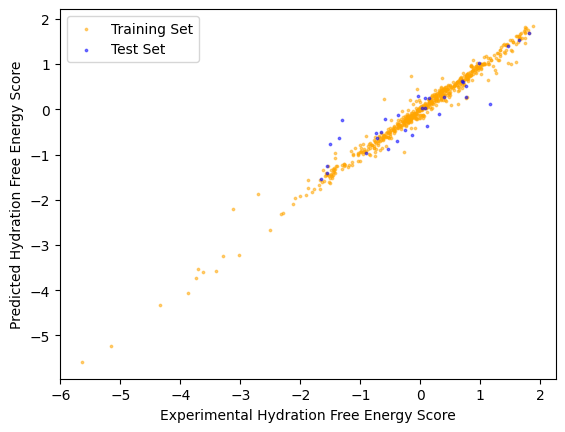

In [ ]:
# Evaluation of model and scatterplot
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
plt.scatter(y_train, y_train_pred, label="Training Set", color = 'orange', alpha = 0.5, s=3)
plt.scatter(y_test, y_test_pred, label="Test Set", color = 'blue', alpha = 0.5, s=3)
plt.legend()
plt.xlabel("Experimental Hydration Free Energy Score")
plt.ylabel("Predicted Hydration Free Energy Score")

# Difficult to pinpoint the horizontal lines if they are present
# The dataset is relatively small as compared to Delaney

In [ ]:
# Display of the duplicates that the model produced
# This happens at about a 5% rate in our dataset.
test["y_pred"] = y_test_pred
train["y_pred"] = y_train_pred
y_train_pred_dups = train[train.duplicated(subset = "y_pred", keep = False)]
print(y_train_pred_dups.shape)
print(y_train_pred_dups.sort_values(by="y_pred"))

(36, 3)
                   smiles         y    y_pred
396           C1CCC(CC1)O -0.430968 -0.480731
22           C1CCCC(CC1)O -0.436169 -0.480731
269  CC(=CCC/C(=C/CO)/C)C -0.168277 -0.226813
15   CC(=CCC/C(=C\CO)/C)C -0.254106 -0.226813
37            CCCCCCCCCCO  0.042396 -0.196131
204               CCCCCCO -0.155272 -0.196131
368            CCCCCCCCCO -0.020025 -0.196131
4                CCCCCCCO -0.105855 -0.196131
437             CCCCCCCCO -0.074644 -0.196131
60              CCCCCCCCN  0.039795 -0.126799
569               CCCCCCN -0.038232 -0.126799
233              CCCCCCCN  0.003383 -0.126799
359            CCCCCCCC=O  0.393518  0.322962
282           CCCCCCCCC=O  0.450738  0.322962
355             CCCCCCC=O  0.294684  0.322962
342        CCCCCCCCC(=O)C  0.380513  0.418545
248         CCCCCCCC(=O)C  0.341500  0.418545
315       CCCCCCCCCC(=O)C  0.429930  0.418545
73           CCCCCCC(=O)C  0.240065  0.418545
129           C(=C/Cl)\Cl  0.786254  0.697304
610           C(=C\Cl)\Cl 

Here we can display a few examples given the previous table of duplicates. It is very clear why our model would produce similar outputs for such extremely similar molecules. If you look at the trained outputs above, you can even compare the SMILES themselves and get an idea as to why a model would think they are alike. This situates itself as one of the weaknesses of using fingerprints as an input.

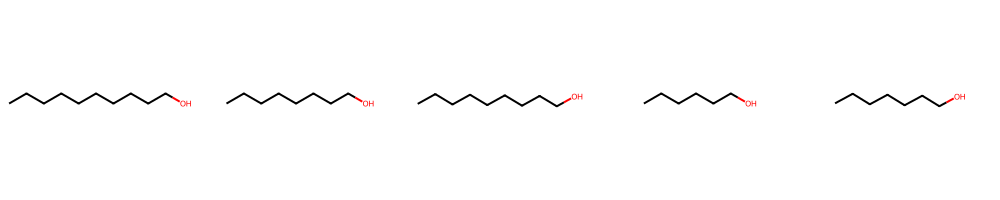

In [ ]:
# Images of the duplicates
dup_check = y_train_pred_dups[y_train_pred_dups.y_pred == y_train_pred_dups.loc[437, "y_pred"]]
dup_check_mols = [Chem.MolFromSmiles(smiles) for smiles in dup_check.smiles]
dup_check_mols_img = Draw.MolsToGridImage(dup_check_mols, molsPerRow=5)
info = {}
dup_check_mols_img

In [ ]:
# Analytical value calculation
print("Average HFE =",np.mean(y_test))
print("Standard Deviation =",np.std(y_test))
print("Root Mean Squared Error =",np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

average_hfe = np.full_like(y_test, np.mean(y_train))
rmse_null_test = np.sqrt(np.mean((y_test - average_hfe)**2))
print("Root Mean Squared Error Null = ", rmse_null_test)

y_test_pred_flat = y_test_pred.flatten()
root_squared_error = np.sqrt((y_test_pred_flat - y_test)**2)
correlation = np.corrcoef(y_test, root_squared_error)[0,1]
print("Correlation =",correlation)

Average HFE = -0.09718536157269621
Standard Deviation = 0.9421357670080633
2/2 [==============================] - 0s 9ms/step
Root Mean Squared Error = 0.38922149863515415
Root Mean Squared Error Null =  0.9476898893231861
Correlation = -0.22795625180073836


The model produces a root mean squared error of around 0.4, which is far lower than the null prediction of around 1. It's easy to notice that the RMSE null and SD values are almost identical. This is because the formulas to produce them are basically identical. The unique thing about RMSE null is that it creates an error value from the average hydration free energy rather than a y_test and associated y_predicted like RMSE does. SD does the same thing with the average HFE. It's important that the RMSE is far lower than the SD because the RMSE predicts a wide variety of HFEs using a wide variety of molecules. If all the molecules predicted the exact same HFE (e.g. the average), that is evidence of extreme overfitting and memorization of the model rather than learning.

The correlation is negative but extremely weak, to a point where it is almost negligible. This implies that as HFE increases, error decreases. The real world application of this information, while questionable, is that the error is lower for molecules with higher HFE and can not be trusted as much for molecules with lower HFE.

Our testing set is 10% of the data. In increments of 5 from 5%, other sets have been checked. The RMSE is not very much affected by this change, meaning the data is not sensitive to choice of training and test set.

##Neural Network Model Using Graph Convolution (RMSE ~0.4)##
As it is a more sophisticated method of machine learning, graph convolution does not make necessary that we convert SMILES data. In fact, SMILES data is not necessary at all because the input is the images of the molecules themselves. DeepChem is a Python library that we make use of in this assignment to retrieve this data, as it already contains the FreeSolv dataset.

Thus, the dataset of molecules is preprocessed in the load_freesolv import, and it recognizes its task of predicting HFE from the molecules. This is a major strength of GraphConv because there is no medium between the molecule itself and the output. It creates its own train, validation, and test sets.

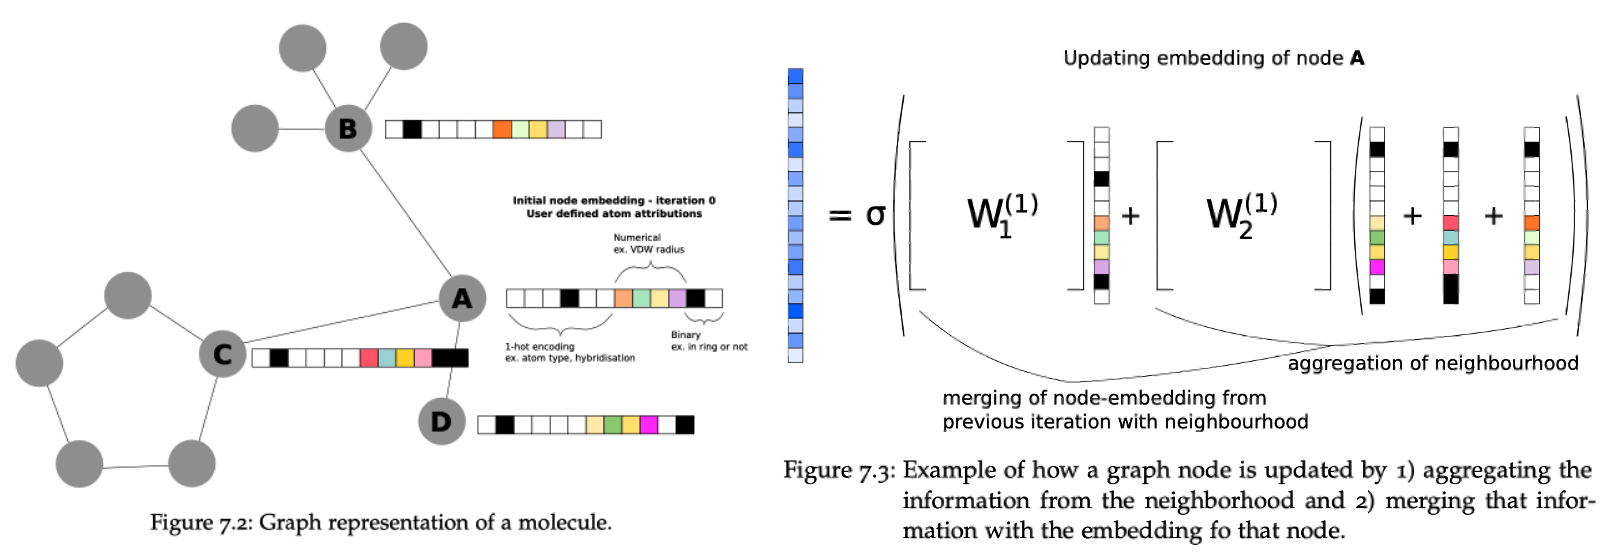

This image explains GraphConv as it is in Maria Harris Rasmussen's thesis. As you can see, bit vectors are created again to convey the variety of features about the molecules that are put through its neural network, with elements as nodes and bonds as edges. The data that goes into the vector can be binary or not, as long as it conveys some specific important feature about the molecule itself.

In [ ]:
# Creation of the model
freesolv_tasks, freesolv_datasets, transformers = load_freesolv(
    featurizer='GraphConv', splitter='random')
train_dataset, valid_dataset, test_dataset = freesolv_datasets
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
model= GraphConvModel(
    n_tasks = len(freesolv_tasks), graph_conv_layers = [32], batch_size=16, batch_normalize= True, dropout = 0.1, mode='regression')

# Fitting the model and producing scores from each of the datasets
model.fit(train_dataset, nb_epoch=100)
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
test_scores = model.evaluate(test_dataset, [metric], transformers)
print("Train Scores")
print(train_scores)
print("Validation Scores")
print(valid_scores)
print("Test Scores")
print(test_scores)

Evaluating model
Train Scores
{'mean_squared_error': 0.0694695747276384}
Validation Scores
{'mean_squared_error': 0.2082600876659485}
Test Scores
{'mean_squared_error': 0.17666821447937112}


0 0.17896295341338903
1 0.17715325495440407
4 0.17314360838338705
10 0.163486771807286


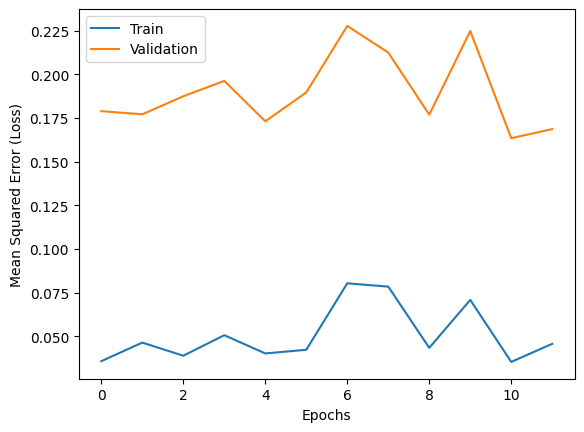

In [ ]:
# Attempting to implement early stop to prevent overfitting and minimize error
train_loss = []
valid_loss = []
max_epochs = 12
lowest_val = 1000
patience = 10
k = 0

for i in range(max_epochs):
  model.fit(train_dataset, nb_epoch = 1)
  train_loss_check = model.evaluate(train_dataset, [metric], transformers)
  valid_loss_check = model.evaluate(valid_dataset, [metric], transformers)
  train_loss.append(train_loss_check["mean_squared_error"])
  valid_loss.append(valid_loss_check["mean_squared_error"])
  k += 1
  if valid_loss_check["mean_squared_error"] < lowest_val:
    lowest_val = valid_loss_check["mean_squared_error"]
    print(i, lowest_val)
    k = 0
  if k == patience:
    print("Training stopped at epoch", i)
    break

plt.plot(range(len(train_loss)), train_loss, label = "Train")
plt.plot(range(len(valid_loss)), valid_loss, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (Loss)")
plt.legend()

Text(0, 0.5, 'Experimental Hydration Free Energy')

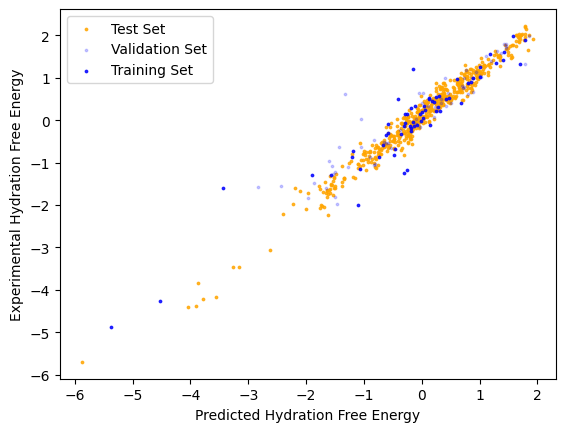

In [ ]:
# Evaluation of scatterplot
y_pred_train = model.predict(train_dataset)
y_train = train_dataset.y
plt.scatter(y_train, y_pred_train, label="Test Set", color = 'orange', alpha = 0.8, s=3)

y_pred_valid = model.predict(valid_dataset)
y_valid = valid_dataset.y
plt.scatter(y_valid, y_pred_valid, label = "Validation Set", color = 'blue', alpha = 0.2, s = 3)

y_pred_test = model.predict(test_dataset)
y_test = test_dataset.y
plt.scatter(y_test, y_pred_test, label="Training Set", color = 'blue', alpha = 0.8, s=3)

plt.legend()
plt.xlabel("Predicted Hydration Free Energy")
plt.ylabel("Experimental Hydration Free Energy")

Text(0, 0.5, 'Experimental Hydration Free Energy')

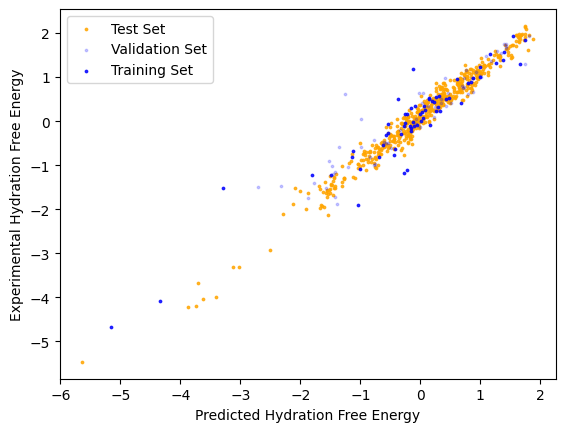

In [ ]:
# Untransforming the data to produce a more accurate scatterplot
# Makes a marginal difference
y_pred_train_act = transformers[0].untransform(y_pred_train)
y_train_act = transformers[0].untransform(y_train)
plt.scatter(y_train_act, y_pred_train_act, label="Test Set", color = 'orange', alpha = 0.8, s=3)

y_pred_valid_act = transformers[0].untransform(y_pred_valid)
y_valid_act = transformers[0].untransform(y_valid)
plt.scatter(y_valid_act, y_pred_valid_act, label="Validation Set", color = 'blue', alpha = 0.2, s=3)

y_pred_test_act = transformers[0].untransform(y_pred_test)
y_test_act = transformers[0].untransform(y_test)
plt.scatter(y_test_act, y_pred_test_act, label="Training Set", color = 'blue', alpha = 0.8, s=3)

plt.legend()
plt.xlabel("Predicted Hydration Free Energy")
plt.ylabel("Experimental Hydration Free Energy")

In [ ]:
# Analytics Calculations
print("Average HFE =",np.mean(y_test_act))
print("Standard Deviation =",np.std(y_test_act))

print("Root Mean Squared Error =",np.sqrt(np.mean((y_test_act - y_pred_test_act)**2)))

average_HFE = np.full_like(y_test_act, np.mean(y_train_act))
rmse_null_test = np.sqrt(np.mean((y_test_act - average_HFE)**2))
print("Root Mean Squared Error Null = ", rmse_null_test)

rse = np.sqrt((y_pred_test_act - y_test_act)**2)
y_test_act_squeeze = np.squeeze(np.asarray(y_test_act))
rse_squeeze = np.squeeze(np.asarray(rse))
correlation = np.corrcoef(y_test_act_squeeze, rse_squeeze)
print("Correlation=",correlation[0,1])

Average HFE = -0.126782275484252
Standard Deviation = 1.1710150051691188
Root Mean Squared Error = 0.4274858742949727
Root Mean Squared Error Null =  1.1804697776226214
Correlation= -0.3840058799352945


The values are not identical, but the same answer applies to the question of the RMSE/RMSE null/SD as it does for the fingerprint neural network. The RMSE is still significantly lower than the RMSE null and the SD, and the RMSE null and SD are still produced using almost the same formula.

The correlation is also very similar in that it is weak and negative, although sightly less weak. It implies that the error will decrease as HFE increases, and that molecules with lower HFE will be more difficult to predict.

The load_freesolv DeepChem import already decides train/validation/test split, so that option is not available, and thus the question of sensitivity is not answerable. The paper states that this is decided as 80/10/10.

The axes are hardly inaccurate to the actual dataset, but untransforming is necessary anyway for proper scatterplot analysis. GraphConv transforms as part of its function.

##Results##
Interestingly, a perfect comparison can not be made. In the fingerprint neural network, a little detail is the inclusion of random_state, which introduces a seed with train_test_split so that the data is replicable. If someone wanted to change particular things, they could depend on the fact that the data that is being set aside for testing and training is identical. I am not sure if load_freesolv uses identical train/valid/test splits each time with GraphConv, however, I can be sure that it is not identical to the seed in the first test. I will disregard this caveat.

The two models, with optimized hyperparameters for RMSE, seem to trade on which displays the most strength on minimizing error. However, the fingerprint bit vector neural network wins out the majority of the time, despit the win being very marginal. This result is interesting because graph convolution is the more sophisticated deep learning method. I am not sure if the reason behind this is something specific about hydration free energy because my chemistry knowledge is not that extensive.

It is possible that graph convolution may perform better with a larger dataset. This dataset of around 600 rows is relatively small when compared with some of the other datasets included in the MoleculeNet paper.

The metrics and featurizers are extensive in choice, but MLM has not expanded into many of them. In the results section of the paper provided, GraphConv is in a toss-up for 3rd and 4th place in terms of minimizing RMSE, with Message Passing Neural Network (MPNN) in the lead. MPNN is not familiar to me.

The models themselves are not so dissimilar given that they produce vectors of data that convey certain information about the molecules. This might explain the similarities in the errors that the models produce. In conclusion, **the fingerprint predictive model is marginally better.**